# Lab Session #4
## Computational Neurophysiology [E010620A]
### Dept of Electronics and Informatics (VUB) and Dept of Information Technology (UGent)
Jorne Laton, Lloyd Plumart, Talis Vertriest, Jeroen Van Schependom, Sarah Verhulst

<font color=blue>Student names and IDs:</font> Cesar Zapata - 02213600
<br>
<font color=blue>Academic Year:</font> 2022-2023

<a id="top"></a> 

# Spiking Stochastics - Decoder and Encoder models

This exercise is adapted from the examples provided in the textbook "Case Studies in Neural Data Analysis", by Mark Kramer and Uri Eden (2016, MIT Press) and the 2020 eLife-LABs publication by Emily Schlafly, Anthea Cheung, Samantha Michalka, Paul Lipton, Caroline Moore-Kochlacs, Jason Bohland, Uri Eden, Mark Kramer. The outline of this exercise follows the theory presented in chapters 7 & 9 of "Neuronal Dynamics" by Gerstner, Kistler, Naud, Paninski (2014, Cambridge University Press). It also uses the principles outlined in Jackson and Carney, 2005 (publication provided with this exercise).

### Aim<a id="introduction"></a>

Here, we go deeper into understanding the stochastics behind neuronal action potential (spiking) generation. We will study the Poisson and Gaussian models and explore ways in which we can fit these point-process models to recorded datasets. In the second part of the exercise, we will consider encoder models that are based on leaky integrate-and-fire models with noisy inputs (8.1 in Gerstner et al.) and apply these models to test a specific research hypothesis related to the spontanous firing rate observed in cat auditory-nerve fibers.
<div class="question">
    
_**Part 1 (Q1-Q4)**_ 

**Data:** Spontaneous spiking activity from a retinal neuron in culture, exposed to low-light and high-light environments. We continue with the dataset from the previous notebook.

**Goal:** Build simple models of interspike interval distributions as a function of the ambient light level.

**Tools:** Interspike interval (ISI) histograms, firing rate, maximum likelihood estimation, Kolmogorov-Smirnov plots, Poisson and Gaussian distributions.
    
_**Part 2 (Q5-Q7)**_ 
    
**Data:** Auditory-nerve spike patterns recorded in the absence of external stimulation from two different fiber types; a low-spontaneous rate fiber, and a high-spontaneous rate fiber.
    
**Goal:** Build decoder models with the same stochastics as observed experimentally.
    
**Tools:** Encoder models, ISI histograms, autocorrelation functions, integrate-and-fire models. 
    
</div>

dict_keys(['__header__', '__version__', '__globals__', 'SpikesLow', 'SpikesHigh'])


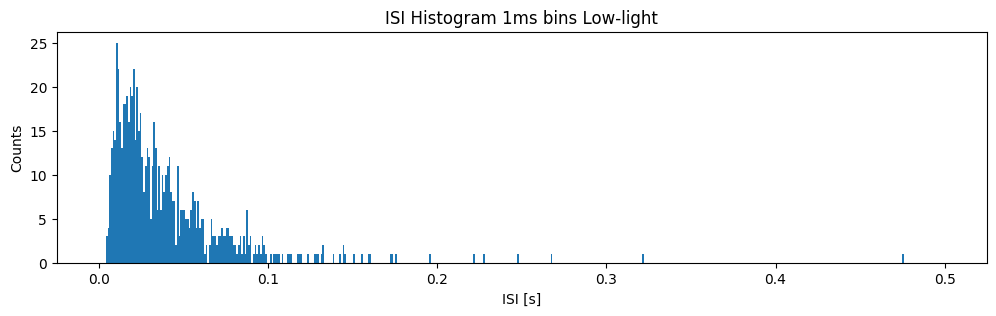

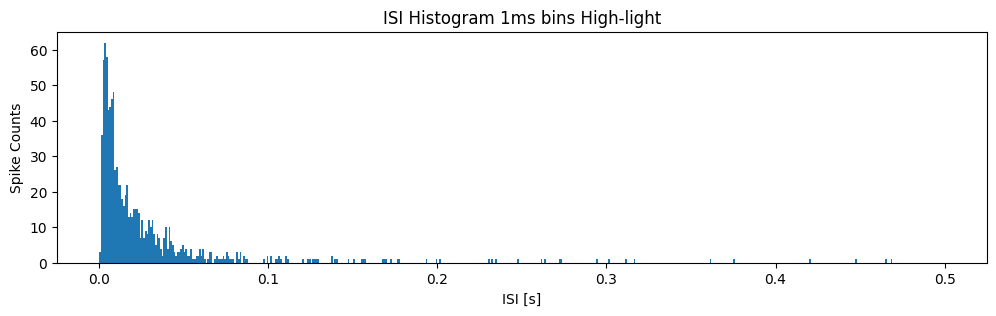

In [1]:
#Run this cell to make sure to have the preambles/data loaded
from pylab import *
import scipy.io as sio
import numpy as np
import random
import warnings
from ffGn_module import ffGn, inhomPP 
%matplotlib inline
rcParams['figure.figsize']=(12,3)  # Change the default figure size

warnings.simplefilter(action='ignore', category=FutureWarning)

data = sio.loadmat('matfiles/08_spikes-1.mat')  # Load the spike train data
print(data.keys())

spikes_low = data['SpikesLow'][0]
spikes_high = data['SpikesHigh'][0]

ISI_low = np.diff(spikes_low)
ISI_high = np.diff(spikes_high)

bin_size = 0.001 # in seconds
bin_edges = arange(0, 0.501, bin_size)  # Define the bins for the histogram

plt.hist(ISI_low, bin_edges)        # Plot the histogram of the low-light ISI data
# xlim([0, 0.15])            # ... focus on ISIs from 0 to 150 ms
ylabel('Counts')
xlabel('ISI [s]')# ... label the y-axis
title('ISI Histogram 1ms bins Low-light')             # ... give the plot a title
plt.show()

plt.hist(ISI_high, bin_edges)       # Plot the histogram of the high-light ISI data
# xlim([0, 0.15])            # ... focus on ISIs from 0 to 150 ms
xlabel('ISI [s]')              # ... label the x-axis
ylabel('Spike Counts')               # ... and the y-axis
title('ISI Histogram 1ms bins High-light')            # ... give the plot a title
plt.show()

## PART 1
#### Q1: Statistical Models   <a id="Q1"></a>

We now consider another powerful technique to understand spiking data, by constructing a ***statistical model*** of the data. This model will capture important features of the data but does not consist of explicit biophysical components, such as (for example) in the Hodgkin-Huxley equations. Statistical models are thus ***phenomenological*** in nature and not biophysically realistic.

To construct a statistical model, we typically assume that the ISIs are indendent samples from an unknown distribution. We then consider a class of statistical distributions that might fit the original data and identify which of these distributions (and its parameters) that provide the best fit to the observed data.

The most basic model we could fit is the Poisson distribution (assumption: the number of spikes in any bin is independent of all previous and future spikes) with an unknown but constant firing rate $\lambda$ ($\nu$ in the lecture slides). The probability $P$ of observing $k$ spikes in any time bin is given by the Poisson distribution,
<a id="eq:1"></a>
$$
  P(k) = \frac{
  \lambda^k e^{-\lambda}
  }{
  k!
  },
  \tag{6}
$$

where $k!$ is the factorial of $k$. Under this model, the distribution for the number of spikes in a bin is Poisson. An important question for our data-set is what the distribution of the waiting times between spikes (i.e., ISIs) looks like? It can be shown mathematically that for any Poisson process with a constant firing rate, the ISIs have an exponential distribution <a href="http://dx.doi.org/10.1007/978-1-4614-9602-1" rel="external">[Kass, Eden & Brown, 2014]</a>. Mathematically, the probability density function for any ISI taking on a value $x$ is
<a id="eq:2"></a>

$$
  f(x) = \lambda \exp(-\lambda x),
  \tag{7}
$$

where $\lambda$ is the rate parameter for the Poisson process.

<div class="math-note">

**Alert 1!** This is a common point of confusion. The increments of a Poisson process have a Poisson distribution, and the ISIs have an exponential distribution. The Poisson distribution takes on non-negative integer values {0,1,...,$\infty$}, which make it appropriate for counting the number of spikes in an interval. The Poisson distribution does not make sense to describe the waiting time between spikes, since this typically takes on a continuous value in [0, $\infty$].

</div>

Our goal is to find a good value of $\lambda$ so that our statistical model $$ f(x) = \lambda \exp(-\lambda x),$$ matches the observed ISI distributions.

**Alert 2!**  The histogram ISI values are in the scale of frequencies, not probabilities, and moreover also binned,thus not taking into account its density. This means that we have to scale the histogram data twice. Once from frequencies to probability and once more to scale it from binned values to preveal the density values. 


* Q1: First make a histogram of the actual data, bin the ISI's in 1ms bins. Then scale your data as described in alert 2 to be able to fit a probability density function. (Control that the total area of your histogram approaches the value of 1). Plot the scaled data together with the exponential probability density function, where you guess a value of $\lambda$ . Now try different values of $\lambda$ and guess which $\lambda$ provides the best visual match. Do these steps for both the low and high light conditions. 

* [Fill in answer here](#A1)

#### Q2: Likelihood functions   <a id="Q2"></a>

The process of guessing values of $\lambda$ and comparing the model to the empirical ISI distribution can be automated by determining the ***likelihood*** function of the joint probability distribution of the data. The goal is to find the value of $\lambda$ that maximizes the likelihood of the data given the statistical model; this value of $\lambda$ will be the best fit of the model to the data. 

To implement this procedure, first consider the probability density of observing a sequence of ISIs, $x_1, x_2, ..., x_n$. If we assume that the ISIs are independent, then the probability density is:
<a id="eq:3"></a>
$$
  \begin{eqnarray}
  f(x_1, x_2, ..., x_n) &=& f(x_1) f(x_2) ... f(x_n) \\ 
  &=& \lambda \exp(-\lambda x_1) \lambda \exp(-\lambda x_2) ... \lambda \exp(-\lambda x_n) \\
  &=& \lambda ^n \exp(-\lambda \sum_{i=1}^n x_i). \\   \tag{8}
  \end{eqnarray}
$$

We call this expression the joint probability distribution of the observed data. In the first equality, we separate the joint probability distribution $f(x_1,x_2,...,x_n)$ into a product of probability distributions of each event (i.e., $f(x_1)$, the probability of the first ISI equaling $x_1$; multiplied by $f(x_2)$, the probability of the second ISI equaling $x_2$; multiplied by $f(x_3)$, the probability of the third ISI equaling $x_3$; and so on). This partitioning of the joint probability is valid here because we assume the ISIs are independent. In the second equality, we replace each probability distribution with the exponential distribution we expect for the ISIs of a Poisson process. In the last equality, we rewrite the expression as a single exponential. Notice that this last expression is a function of the unknown rate parameter, $\lambda$.

When considered as a function of the unknown parameters, the joint distribution of the data is also called the *likelihood*. In this case, we write
<a id="eq:4"></a>
$$
  L(\lambda) = \lambda^n e^{-\lambda (x_1 + x_2 + ... + x_n)},
  \tag{9}
$$

to indicate that the likelihood $L$ is a function of $\lambda$.

* Q2.1: Plot the likelihood function $L(\lambda)$ for each light condition and consider a range of $\lambda$ values. Evaluate the maxima carefully, does the result make sense when considering the equation? If the result doesn't make sense at first, do not panic. It is a feature, not a bug.

* Q2.2: Plot the log of the likelihood instead, and identify which $L(\lambda)$s are a good fit to the low and high-light conditions. The $\lambda$, where the log likelihood is maximized, is called the **maximum likelihood estimate** of $\lambda$: $\hat\lambda$.
The log-likelihood function is:
<a id="eq:4"></a>
$$
  l(\lambda) = n\ln{(\lambda)}-\lambda (x_1 + x_2 + ... + x_n),
  \tag{10}
$$

* Q2.3: Is the difference in the Poisson rate parameter between the low-and high-light conditions statistically significant? To address this last question, we can use a bootstrap analysis. Combine all the ISIs from both conditions into one pool, sample many (1000) new datasets with values randomly selected from that pool. Plot the distribution of the differences accross the 1000 samples as a histogram, together with the actual difference in both original rate parameters. Compare the results, what is your conclusion?

* [Fill in answer here](#A2)

#### Q3: Goodness of Fit  <a id="Q3"></a>

We assumed that the spikes were generated according to a poisson process, but is the exponential pdf that we created a good fit for the ISI? 

* Q3.1: To answer this, first compare the model fits and the scaled data visually. Therefore plot again the exponential pdf (with the optimal $\lambda$) together with the scaled histogram values. Compare the expected proportion of ISIs for a Poisson process to the ISI histograms we actually observe in each condition. What is your conclusion?

To go beyond visual inspection and quantify the goodness of fit, we compare the cumulative distributions computed from the scaled data and the model. The ***cumulative distribution function (CDF)***, $F(x)$, is the probability that a random variable will take on a value less than or equal to $x$. For the exponential ISI model with rate parameter $\lambda$, the model CDF is

$$
  \begin{eqnarray}
  F_{mod}(x) &=& \Pr(\mbox{ISI} \leq x) \\
  &=& \int_0^x \lambda e^{-\lambda t} dt \\
  &=& 1 - e^{-\lambda x}.
  \end{eqnarray}
$$

We compare this to the empirical CDF of the data, $F_{emp}(x)$, which is defined as the proportion of observations less than or equal to $x$. In other words, this is the cumulative sum of all previous areas of the histogram, not just cumulative sum of the scaled probability density values. Scale your empirical data correctly, the last value should approach 1.

* Q3.2: Compute and plot the CDF function together with the empirical values. Evaluate how well the model fits the empirical data. Do this for both conditions and compare the CDF models according to its light condition.

* Q3.3: Another common way to visualize the difference between the model and empirical distributions is a ***Kolmogorov-Smirnov(KS)*** plot. This is a plot of the empirical CDF against the model CDF directly. Since the KS plot compares CDFs, both the $x$-axis and $y$-axis range from 0 to 1. A perfect fit between the model and empirical CDFs would look like a straight, 45-degree line between the points (0,0) and (1,1). Any deviation from this line represents deviation between the observed and model distributions. One nice result for comparing CDFs is that with enough data, the maximum difference between the model and empirical CDFs has a known asymptotic distribution, which can be used to put confidence bounds about the KS plot <a href="http://dx.doi.org/10.1007/978-1-4614-9602-1" rel="external">[Kass, Eden & Brown, 2014]</a>. For 95% confidence bounds, a well-fit model should stay within ±1.36/$\sqrt N$ of the 45-degree line, where $N$ is the number of ISIs observed. Let’s place these confidence bounds on the KS plot and determine whether your model fits the data well.

* [Fill in answer here](#A3)

#### Q4: More advanced, inverse Gaussian probability models. <a id="Q4"></a>

So far, we investigated how well one class of models, the exponential distribution function, fits the observed ISI distributions. However, this type of statistical model is not always sufficient to mimic the observed data. There are many other choices for statistical models; and here we'll try one other class of models: the inverse Gaussian probability model. This model has previously been used successfully to describe ISI structures <a href="https://www.ncbi.nlm.nih.gov/pubmed/9394447" rel="external">[Iyengar & Liao, 1997]</a>) and the mathematical expression for the inverse Gaussian probability density is,

$$
  f(x) = \sqrt{\frac{\lambda}{2 \pi x^3}}\exp\left(\frac{-\lambda(x - \mu)^2}{2 x \mu^2}\right) \, .
  \tag{10}
$$

The inverse Gaussian distribution has two parameters that determine its shape: $\mu$, which determines the mean of the distribution; and $\lambda$, which is called the shape parameter. At $x$ = 0, the inverse Gaussian has a probability density equal to zero, which suggests it could capture some of the refractoriness seen in the data.

If we again assume that the ISIs are independent of each other, then the likelihood of observing the sequence of ISIs, $x_1 , x_2 , . . . , x_n$, is the product of the probabilities of each ISI,

$$
  L(\mu, \lambda) = f(x_1, x_2, ..., x_n) = \prod_{i=1}^N\sqrt{\frac{\lambda}{2\pi x_i^3}}\exp\left(\frac{-\lambda(x_i - \mu)^2}{2 x_i \mu^2}\right)
  \tag{11}
$$

The log likelihood is then

$$
  \log\big(L(\mu, \lambda)\big) = \frac{N}{2}\log\frac{\lambda}{2\pi} - \frac{3}{2}\sum_{i=1}^N \log{x_i} - \sum_{i=1}^N\frac{\lambda(x_i - \mu)^2}{2x_i \mu^2}
  \tag{12}
$$

Since this distribution has two parameters, the maximum likelihood solution for this model is the pair of parameter estimates $\hat\mu$, $\hat\lambda$ that maximizes the likelihood of the data. We can solve for the maximum likelihood estimate analytically by taking the derivative with respect to both parameters, setting these equal to zero, and solving the resulting set of equations. In this case, the maximum likelihood estimators are

$$
  \hat\mu = \frac{1}{N}\sum_{i=1}^N x_i
  \tag{13}
$$

and

$$
  \hat\lambda = \left( \frac{1}{N}\sum_{i=1}^N\left(\frac{1}{x_i} - \frac{1}{\bar \mu}\right)\right)^{-1}
  \tag{14}
$$

* Q4.1 : Use this expression to fit an inverse Gaussian model to the scaled data in each condition. Again, make sure you scale the empirical data correctly to the model and plot them together.

* Q4.2: Consider the goodness-of-fit of the model in the two conditions. Does the inverse Gaussian model provide a good fit to the ISIs, and motivate why (or why not) this model is better fit? (calculate the CDF of both the inverse gaussian and the empirical data. Again, use the Ks plot to evaluate.)

* Q4.3: Compare the $\mu$ and $\lambda$ estimates between the two conditions. What can you conclude about the differences between the low- and high-light conditions?

* [Fill in answer here](#A4)

## PART 2
#### Q5: From Decoding to Encoding models <a id="Q5"></a>

Identifying the best fitting model and its parameters helps us to understand and describe spiking statistics of a variety of neurons, and this process is called ***Decoding***. However, when developing neuronal models or mimicking physiological processes in machines (e.g. robots) one would like to follow an ***Encoding*** approach in which we provide a stimulus to a model of the neuron and predict a spiking pattern that mimics that of the biophysical system. Well-designed encoding models can generate spiking patterns to any stimulus (e.g. Hodgkin-Huxkley type of neuronal models with escape noise), but for simplicity, we will focuss on simulating the spiking statistics of auditory-nerve models when spiking at their spontaneous rate (i.e. without external simululation applied). Indeed, spiking can occur in the absence of stimuluation because there is always some sort of neuronal/background noise present in biological systems that can drive the neuron temporarily above its firing threshold and generate sporadic spikes. Neurons or nerve fibers are therefore often characterised by their ***Spontaneous Rate (SR)*** i.e. the number of spikes/s (firing rate) generated in the absence of external stimulation.

Much of what we know about the auditory-nerve fibers (i.e. connection between the sensory cochlear inner-hair-cells and the spiral ganglion cells and auditory nerve bundle) stems from the characterisation of single-unit neuronal recordings in cats made by <a href="https://apps.dtic.mil/sti/citations/AD0633419" rel="external">[Nelson Kiang, 1965]</a> and <a href="<https://asa.scitation.org/doi/abs/10.1121/1.381736" rel="external">[Charles M Liberman, 1978]</a>. The below picture provides a good overview of the distribution of different spontaneous rates that were found from a large number fo single-unit of recordings (in the absence of external stimulation). Taken from <a href="https://link.springer.com/content/pdf/10.1007/s10162-005-5045-6.pdf" rel="external">[Jackson and Carney, 2005]</a>

<img src='.matfiles/SRANfigure.png' width="400" height="400">

The authors of the last paper pose that the distribution of observed SRs fibers can be generated using ***Poisson-equivalent integrate-and-fire models*** for two or three fixed SR values. In other words, the stochastics of the underlying spike generation process is such that the observed SR distribution can be observed even when only two/three types of SR-AN fibers exist. Here, you will implement the proposed encoder model and compare it to a standard poisson-based encoder model.        

* Q5.1 : First, determine (decode) the model parameters given recordings of two different AN fibers. Load in the data, and determine the $\hat\lambda$ and $\hat\mu$ parameters for both low and high-spontaneous rate AN fibers using an inverse Gaussian model. Plot again as done in Q4   

* [Fill in answer here](#A5)

#### Q6: Inhomogeneous integrate-and-fire encoder model <a id="Q6"></a>

Next, you can implement the encoding principle as outlined in <a href="https://link.springer.com/content/pdf/10.1007/s10162-005-5045-6.pdf" rel="external">[Jackson and Carney, 2005]</a>. 

The authors suggest that a poisson process (i.e., each spike is generated independently from the previous spike times) cannot account for the observed behavior, instead the encoder model should include a ***long-range temporal dependence (LRD)*** which is characterised by the ***Hurst exponent (H)***. The hurst index is a measure of the long-term memory of a time series and relates to the rate at which the autocorrelation of a time series decreases as the lag between pairs of spike times increases. It quantifies the relative tendency of a time series to either regress strongly to the mean or to cluster in a specific direction. 

* A value of H=0.5 reflects an exponential decay and describes a completely uncorrelated series (i.e. Poisson process). For this series, the absolute values of the autocorrelation function decays exponentially quickly to zero.

* Differently, for values of H: 0.5 - 1, there is LRD and the time serie has a long-term positive autocorrelation, i.e. the autocorrelations decay so slowly that their sum diverges to infinity. This means that a late spike in the series will probably be followed by a spike after a long ISI, and that the late spikes will all be characterised by long ISIs.

The authors suggest that the spontaneous rate histogram can be created by a ***fractal-Gaussian-noise-driven inhomogeneous poisson process (fGnDP)***, a type of escape noise model (chapter 9.4.1 in Gerstner) that consists of a doubly stochastic Poisson process, wherein the stochastic process that serves as an input to a poisson-equivalent integrate-fire model is a fractal-Gaussian noise (fGn) that can be made to contain LRD by modifying the Hurst index. 

* Q6.1: Before we generate the spikes, let's first generate the escape noise (fGn). Generate a noisy output signal of 30-s length (FS = 1000 Hz) that has a mean rate equal to the SR of the fiber and that either follows a poisson process (H=0.5) or has LRD (H=0.95). Consider the SR 80 spikes/s. Note that even if H=0.5, the underlying SR distribution follows an inhomogeneous poisson process, where the rate varies due to pure white noise which is gaussian distributed around the mean SR. In the case of LRD (H=0.95), the distribution of the SR still follows an inhomogeneous poisson process, but the rate now varies due to white noise that also contains the effect of LRD. With the `ffGn(N, dt, H, SR)` function you can create both SR signals over time, one time for H=0.5 and one time for H=0.95. Note that in both cases (H=0.5 and H=0.95) the SR signal returned, has a mean of 0, to which you need to add the SR. Plot the time series of both noise signals, do you notice differences? This signal is equivalent to the $\Lambda(t)$ signal in the paper. Next, plot the autocorrelation function of the two noises (ACF, see previous exercise) and describe + interpret the differences between the two curves. 

* Q6.2: In the second phase, feed the noise signal returned by the ffGn function as `in` to an inhomogenous integrate-and-fire neuron, which will output a list of spike times, given the noisy SR time-domain signal. The function works as follows: `spiketimes, PSref = inhomPP(in,dt)`. `PSref` is a control value that gives the poisson spike times that were on the basis of the inhomogeneous integrate-and-fire calculation. Compare the characteristics (ISI's) of the following models: a) inhomPP with H=0.5 input, b) inhomPP with H=0.95 input and c) the PSref basis spike times (those take a rate of 1 spike/s). Plot the three model's ISI's through a histogram with 1ms bins. Do your results align with expectations, why/why not? 

* [Fill in answer here](#A6)

#### Q7: Investigate the research hypothesis <a id="Q7"></a>

In the last step of this exercise, you should repeat the numerical experiment that Jackson and Carney performed to conclude that an inhomogeneous poisson process with 2/3 SR and includes LRD, is able to replicate the histogram characteristics (ISI's) of the reference AN SR distribution. You should also compare your outcomes with the figure when using Poisson-based (H=0.5) fGn as input to the inhomogeneous integrate-and-fire model. 

* Q7.1: To obtain the histogram, you should compute the mean SR (spikes/s) in a repeated experiment, where you simulate the spike times in 30-s windows (using your encoder of choise) and repeat this experiment 150 times. You will need to use a for-loop for this. Consider the SRs of -20, 10 and 80 spikes/s and use FS = 1000 Hz. Compare your histograms with the reference figure and between Poisson, LRD models. Was their hypothesis sensible?

* [Fill in answer here](#A7)

## Answers
#### A1: Statistical Models  <a id="A1"></a>
* [Go back to Q1](#Q1) 

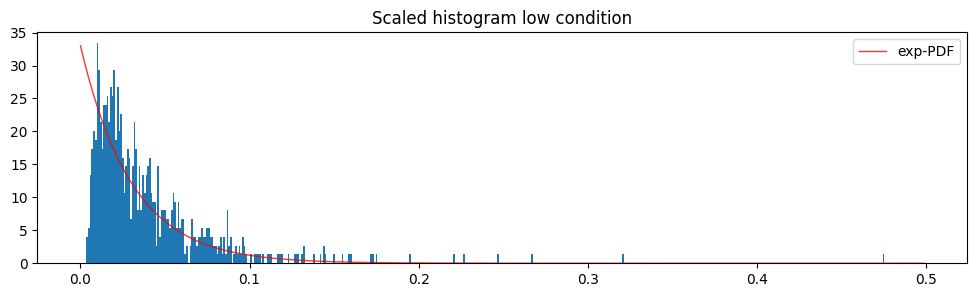

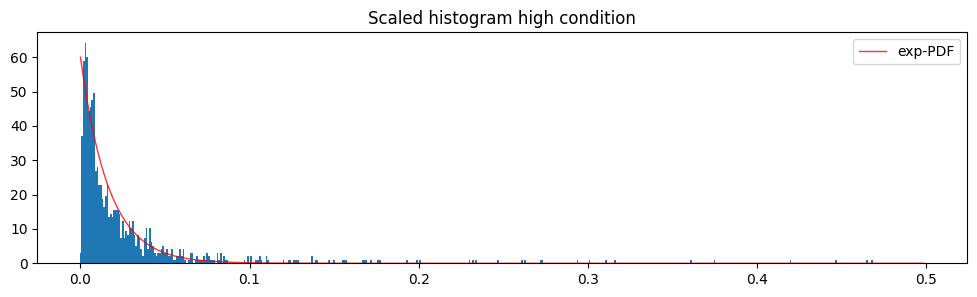

In [2]:
# use the following variables:
# ISI_low (ISI's for low light)
# ISI_high (ISI's for high light)
# prob_density_low (y axis values of the scaled histogram of ISI in 1ms bins, low light condition)
# prob_density_high (y axis values of the scaled histogram of ISI in 1ms bins, high light condition)
# bin_edges
# bin_mids
# N_low (total number of ISI's, low light)
# N_high (total number of ISI's, high light)
# exp_pdf_low (exponential pdf, low light)
# exp_pdf_high (exponential pdf, high light)

######################
##   Q.1 solution   ##
######################

# Low
N_low = len(ISI_low)
freqs_low, bins_low = np.histogram(ISI_low, bins=bin_edges)
prob_density_low = freqs_low / N_low / bin_size

lambda_low = 33
exp_pdf_low = [(lambda_low * exp(-lambda_low * x)) for x in bin_edges[:-1]]

# plotting
plt.bar(bin_edges[:-1], prob_density_low, width=bin_size)
plt.plot(bin_edges[:-1], exp_pdf_low, label="exp-PDF", color='r', alpha=0.8, linewidth=1)
plt.legend()
plt.title("Scaled histogram low condition")
plt.show()


# High 
N_high = len(ISI_high)
freqs_high, bins_high = np.histogram(ISI_high, bins=bin_edges) 
prob_density_high = freqs_high / N_high / bin_size

lambda_high = 60
exp_pdf_high = [(lambda_high * exp(-lambda_high * x)) for x in bin_edges[:-1]]

# plotting
plt.bar(bin_edges[:-1], prob_density_high, width=bin_size)
plt.plot(bin_edges[:-1], exp_pdf_high, label="exp-PDF", color='r', alpha=0.8, linewidth=1)
plt.legend()
plt.title("Scaled histogram high condition")
plt.show()

<div class="alert alert-success">
<span style="color:black">

**A1 conclusion** 
    
\begin{tcolorbox}[colback=green!5]
    
Your answer here

\end{tcolorbox}
    
</span>

#### A2: Likelihood functions  <a id="A2"></a>
* [Go back to Q2](#Q2) 

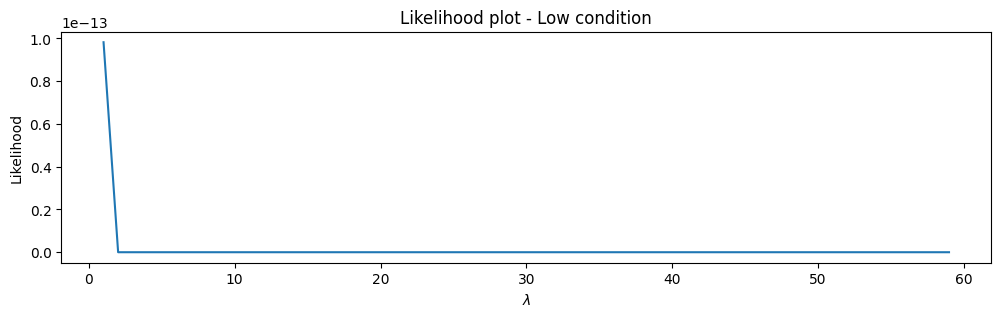

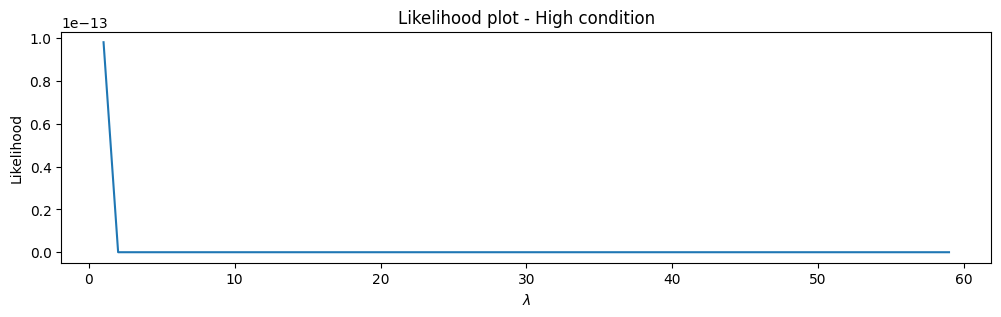

In [3]:
# hint, exclude lambda = 0 in your range of lambdas.

# Q2.1: use the following variables:
# likelihood_low      (for your likelihood model, low light)
# likelihood_high      (for your likelihood model, high light)

######################
##  Q2.1 solution   ##
######################

# low condition
lambda_arr = np.arange(1, 60)
likelihood_low = lambda_arr ** len(ISI_low) * exp(-lambda_arr * sum(ISI_low))

# plotting
plt.plot(lambda_arr, likelihood_low)
plt.title("Likelihood plot - Low condition")
plt.xlabel("$\lambda$")
plt.ylabel("Likelihood")
plt.show()

# high condition
likelihood_high = lambda_arr ** len(ISI_high) * exp(-lambda_arr * sum(ISI_high))

# plotting
plt.plot(lambda_arr, likelihood_high)
plt.title("Likelihood plot - High condition")
plt.xlabel("$\lambda$")
plt.ylabel("Likelihood")
plt.show()

<div class="alert alert-success">
<span style="color:black">
    
**A2.1 conclusion** 

\begin{tcolorbox}[colback=green!5]
    
Your answer here

\end{tcolorbox}
</span>

Max low idx: 25
max low -> 1661.5802582620117


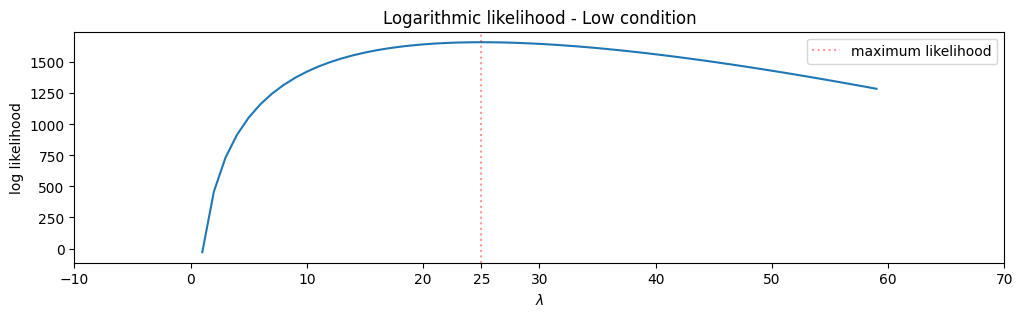

Max high idx: 32
max high -> 2396.2088712744653


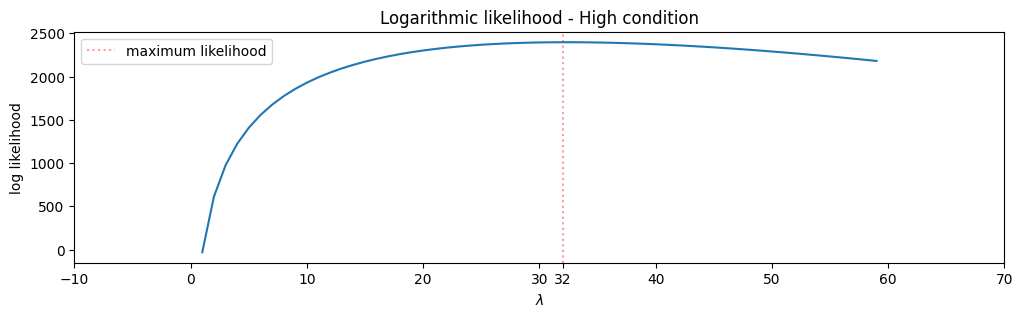

In [4]:
# Q2.2: use the following variables:

# log_likelihood_low (for your log_likelihood model, low light)
# log_likelihood_high (for your log_likelihood model, high light)

# max_likelihood_lambda_low (for the optimal lambda value, low light)
# max_likelihood_lambda_high (for the optimal lambda value, high light)

######################
##  Q2.2 solution   ##
######################

# low condition
log_likelihood_low = len(ISI_low) * log(lambda_arr) - lambda_arr * sum(ISI_low) # from 1 so we exclude the 0 value from the logarithm
# print(f"Max log low: {max(log_likelihood_low)}")
max_idx_low = np.where(log_likelihood_low ==  max(log_likelihood_low))[0][0] + 1
max_likelihood_lambda_low = log_likelihood_low[max_idx_low]
print(f"Max low idx: {max_idx_low}")
print(f"max low -> {max_likelihood_lambda_low}")


plt.plot(lambda_arr, log_likelihood_low)
plt.axvline(x=max_idx_low, color='r', label="maximum likelihood", alpha=0.4, ls='dotted')
plt.title("Logarithmic likelihood - Low condition")
plt.xlabel("$\lambda$")
plt.ylabel("log likelihood")
plt.legend()
x_ticks = np.append(plt.xticks()[0], max_idx_low)
plt.xticks(x_ticks)
plt.show()

# high condition
log_likelihood_high = len(ISI_high) * log(lambda_arr) - lambda_arr * sum(ISI_high)
max_idx_high = np.where(log_likelihood_high ==  max(log_likelihood_high))[0][0] + 1 
max_likelihood_lambda_high = log_likelihood_high[max_idx_high]
print(f"Max high idx: {max_idx_high}")
print(f"max high -> {max_likelihood_lambda_high}")


plt.plot(lambda_arr, log_likelihood_high)
plt.axvline(x=max_idx_high, color='r', label="maximum likelihood", alpha=0.4, ls='dotted')
plt.title("Logarithmic likelihood - High condition")
plt.xlabel("$\lambda$")
plt.ylabel("log likelihood")
x_ticks = np.append(plt.xticks()[0], max_idx_high)
plt.xticks(x_ticks)
plt.legend()
plt.show()

1717


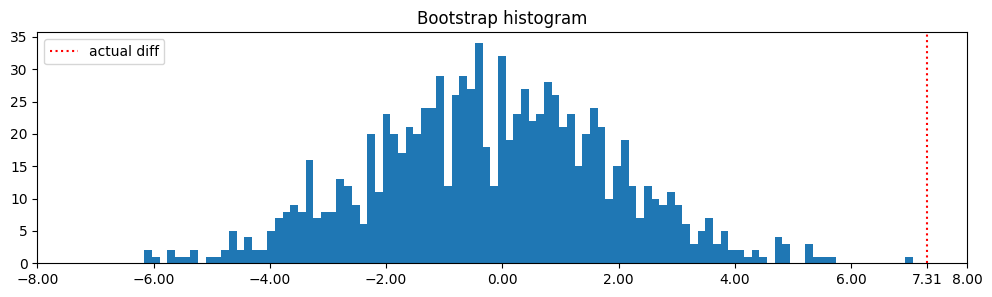

In [6]:
# from random import sample
# use the following parameters:
# N_all (N_low + N_high)
# mean_lambda_diff (1 digit value)
# sample_diff (array with 1000 difference values)

######################
##  Q2.3 solution   ##
######################
N_all = N_low + N_high
print(N_all)
pool = np.array(list(ISI_low) + list(ISI_high))

# 1 / mean(ISIs[randint(Nall, size=Nhi)]

sample_diff = np.zeros(1000)
for i in range(1000):
    art_low = pool[randint(N_all, size=N_low)]
    art_high = pool[randint(N_all, size=N_high)]
    sample_diff[i] = (1 / np.mean(art_high)) - (1 / np.mean(art_low))

mean_lambda_diff = (1 / np.mean(ISI_high)) - (1 / np.mean(ISI_low))


# plotting histograms
plt.hist(sample_diff, bins=100)
plt.axvline(x=mean_lambda_diff, color='r', label="actual diff", ls='dotted')
x_ticks = np.append(plt.xticks()[0], mean_lambda_diff)
plt.xticks(x_ticks)
plt.legend()
plt.title("Bootstrap histogram")
plt.show()

<div class="alert alert-success">
<span style="color:black">
    
**A2.3 conclusion** 

\begin{tcolorbox}[colback=green!5]
    
Your answer here

\end{tcolorbox}
</span>

#### A3: Goodness of Fit  <a id="A3"></a>
* [Go back to Q3](#Q3) 

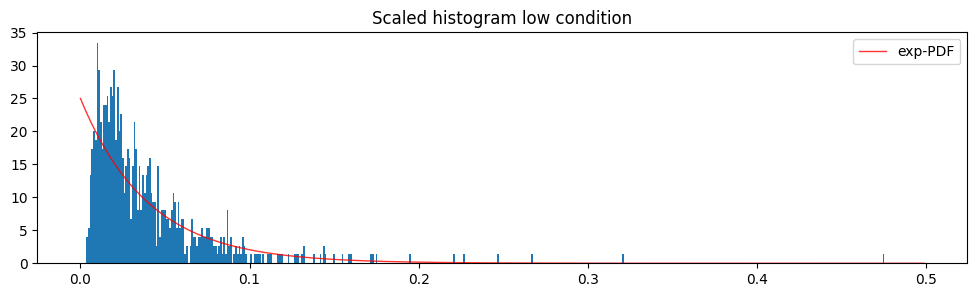

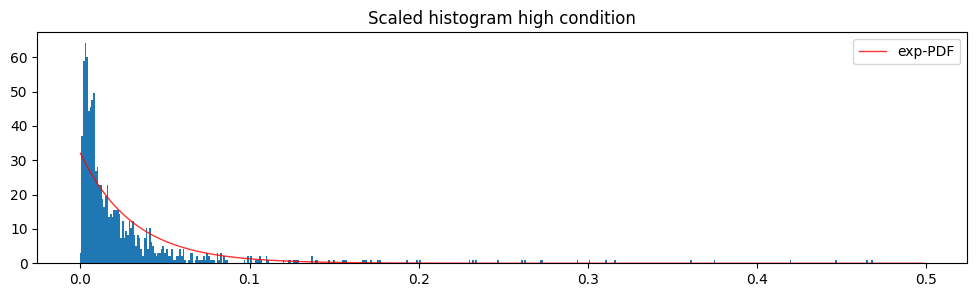

integral low: 1.0000000000000002
integral high: 0.9958677685950414


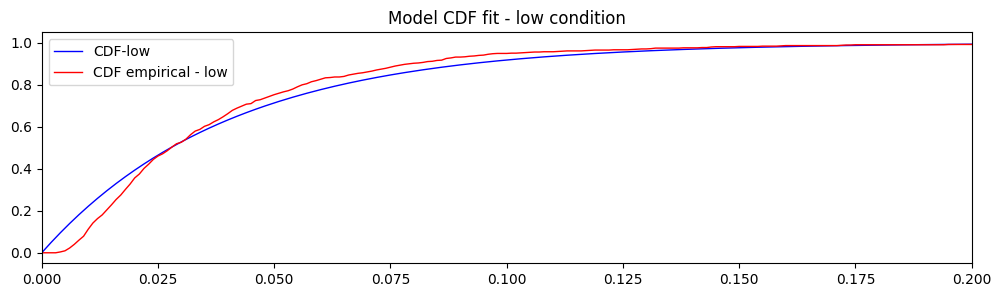

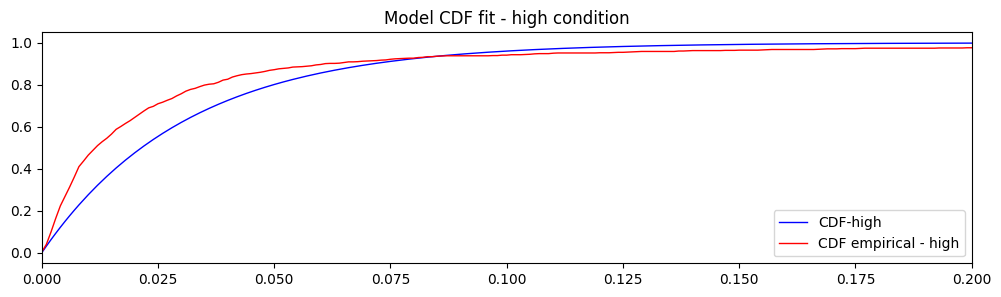

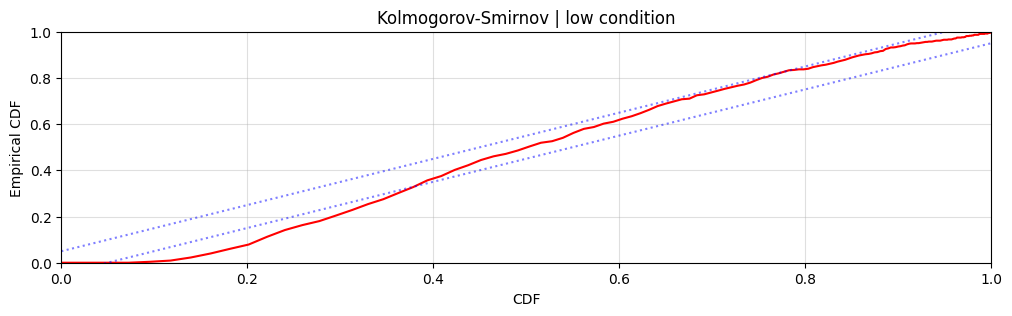

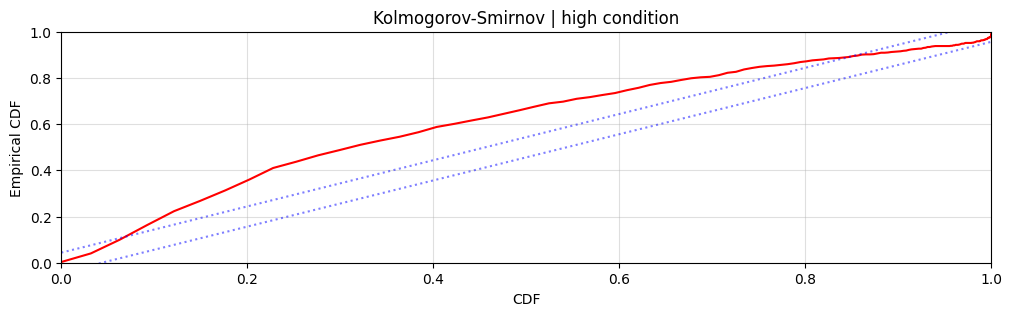

In [18]:
# use the following parameters
# ISI_low (ISI's for low light)
# ISI_high (ISI's for high light)
# prob_density_low (y axis values of the scaled histogram of ISI in 1ms bins, low light condition)
# prob_density_high (y axis values of the scaled histogram of ISI in 1ms bins, high light condition)
# bin_edges
# bin_mids
# N_low (total number of ISI's, low light)
# N_high (total number of ISI's, high light)
# exp_pdf_low (exponential pdf, low light)
# exp_pdf_high (exponential pdf, high light)
# CDF_exp_low (the CDF function of the exponential pdf, low light)
# CDF_exp_high (the CDF function of the exponential pdf, high light)
# CDF_emp_low (empirical values, low light)
# CDF_emp_high (empirical values, high light)

#######################
##   Q3.1 solution   ##
#######################

'''
- Plot again the exponential pdf (with the optimal lambda) together with the scaled histogram values
- Compare the expected proportion of ISIs for a Poisson process to the actual ISI histograms we observe -> conclusion?
'''

# low condition
exp_pdf_low = [(max_idx_low * exp(-max_idx_low * x)) for x in bin_edges[:-1]]
plt.bar(bin_edges[:-1], prob_density_low, width=bin_size)
plt.plot(bin_edges[:-1], exp_pdf_low, label="exp-PDF", color='r', alpha=0.8, linewidth=1)
plt.legend()
plt.title("Scaled histogram low condition")
plt.show()

# high condition 
exp_pdf_high = [(max_idx_high * exp(-max_idx_high * x)) for x in bin_edges[:-1]]
plt.bar(bin_edges[:-1], prob_density_high, width=bin_size)
plt.plot(bin_edges[:-1], exp_pdf_high, label="exp-PDF", color='r', alpha=0.8, linewidth=1)
plt.legend()
plt.title("Scaled histogram high condition")
plt.show()

print(f"integral low: {sum(prob_density_low) * 0.001}\nintegral high: {sum(prob_density_high) * 0.001}")


######################
##  Q3.2 solution   ##
######################

'''
- Compute and plot the CDF together with the empirical values
- Evaluate how well the model fits the empirical data -> for both conditions
- Compare CDF models according to its light condition
'''

# for low light condition
lambda_low = 1 / np.mean(ISI_low)
CDF_exp_low = 1 - exp(-lambda_low * bin_edges)
pdf_low = freqs_low / N_low
CDF_emp_low = cumsum(pdf_low)

plt.plot(bin_edges, CDF_exp_low, label="CDF-low", color='b', linewidth=1)
plt.plot(bin_edges[:-1], CDF_emp_low, label="CDF empirical - low", color='r', linewidth=1)
plt.legend()
plt.title("Model CDF fit - low condition")
plt.xlim([0, 0.2])
plt.show()

# for high light condition
lambda_high = 1 / np.mean(ISI_high)
CDF_exp_high = 1 - exp(-lambda_high * bin_edges)
pdf_high = freqs_high / N_high
CDF_emp_high = cumsum(pdf_high)

plt.plot(bin_edges, CDF_exp_high, label="CDF-high", color='b', linewidth=1)
plt.plot(bin_edges[:-1], CDF_emp_high, label="CDF empirical - high", color='r', linewidth=1)
plt.legend()
plt.title("Model CDF fit - high condition")
plt.xlim([0, 0.2])
plt.show()


######################
##  Q3.3 solution   ##
######################

'''
- Kolmogorov-Smirnov plot
'''
# low condition
plt.plot(CDF_exp_low[:-1], CDF_emp_low, color='r')   
plt.plot([0, 1], [x + 1.36 / sqrt(N_low) for x in [0, 1]], ':', color='b', alpha=0.5)
plt.plot([0, 1], [x - 1.36 / sqrt(N_low) for x in [0, 1]], ':', color='b', alpha=0.5)
plt.axis([0, 1, 0, 1])       
plt.xlabel('CDF')           
plt.ylabel('Empirical CDF')
plt.title("Kolmogorov-Smirnov | low condition")
plt.grid(alpha=0.4)
plt.show()

# high condition
plt.plot(CDF_exp_high[:-1], CDF_emp_high, color='r')   
plt.plot([0, 1], [x + 1.36 / sqrt(N_high) for x in [0, 1]], ':', color='b', alpha=0.5)
plt.plot([0, 1], [x - 1.36 / sqrt(N_high) for x in [0, 1]], ':', color='b', alpha=0.5)
plt.axis([0, 1, 0, 1])       
plt.xlabel('CDF')           
plt.ylabel('Empirical CDF')
plt.title("Kolmogorov-Smirnov | high condition")
plt.grid(alpha=0.4)
plt.show()

<div class="alert alert-success">
<span style="color:black">
    
**A3.1 conclusion** 

\begin{tcolorbox}[colback=green!5]
    
Your answer here

\end{tcolorbox}
</span>

<div class="alert alert-success">
<span style="color:black">
    
**A3.2 conclusion** 

\begin{tcolorbox}[colback=green!5]
    
Your answer here

\end{tcolorbox}
</span>

<div class="alert alert-success">
<span style="color:black">
    
**A3.3 conclusion** 

\begin{tcolorbox}[colback=green!5]
    
Your answer here

\end{tcolorbox}
</span>

#### A4: More advanced, inverse Gaussian probability models   <a id="A4"></a>
* [Go back to Q4](#Q4) 

C:\Users\cesar\AppData\Local\Temp\ipykernel_8244\2388602589.py:19: RuntimeWarning: divide by zero encountered in divide
  inv_gaussian_low = ( sqrt(lambda_low / (2 * np.pi * bin_edges ** 3)) * exp(-lambda_low * (bin_edges - mu_low) ** 2 / (2 * mu_low ** 2 * bin_edges)) * 0.001)
C:\Users\cesar\AppData\Local\Temp\ipykernel_8244\2388602589.py:19: RuntimeWarning: invalid value encountered in multiply
  inv_gaussian_low = ( sqrt(lambda_low / (2 * np.pi * bin_edges ** 3)) * exp(-lambda_low * (bin_edges - mu_low) ** 2 / (2 * mu_low ** 2 * bin_edges)) * 0.001)
C:\Users\cesar\AppData\Local\Temp\ipykernel_8244\2388602589.py:26: RuntimeWarning: divide by zero encountered in divide
  inv_gaussian_high = ( sqrt(lambda_high / (2 * np.pi * bin_edges ** 3)) * exp(-lambda_high * (bin_edges - mu_high) ** 2 / (2 * mu_high ** 2 * bin_edges)) * 0.001)
C:\Users\cesar\AppData\Local\Temp\ipykernel_8244\2388602589.py:26: RuntimeWarning: invalid value encountered in multiply
  inv_gaussian_high = ( sqrt(lambda_

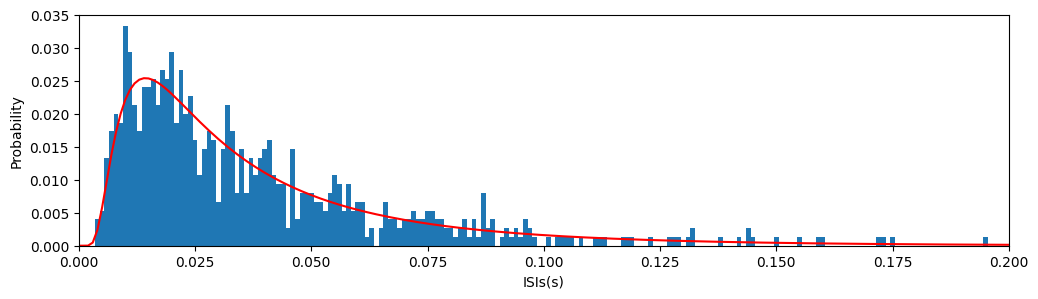

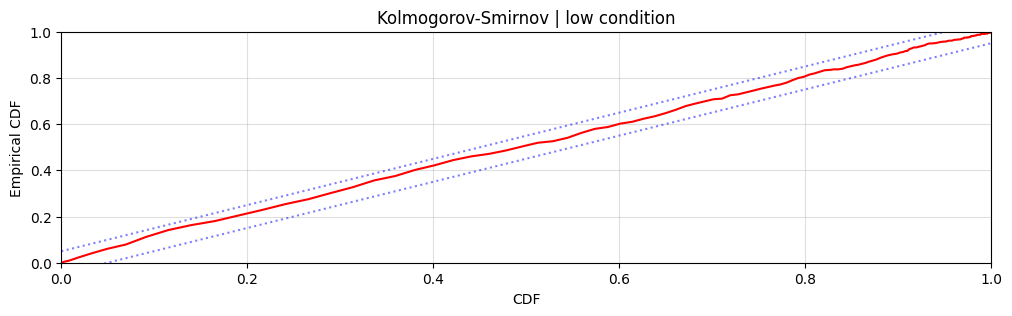

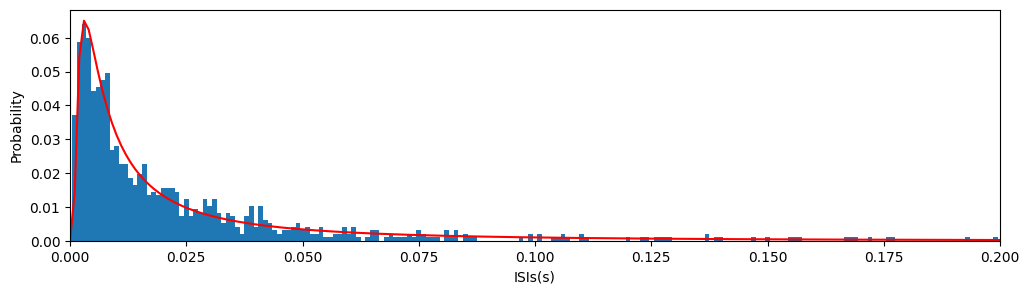

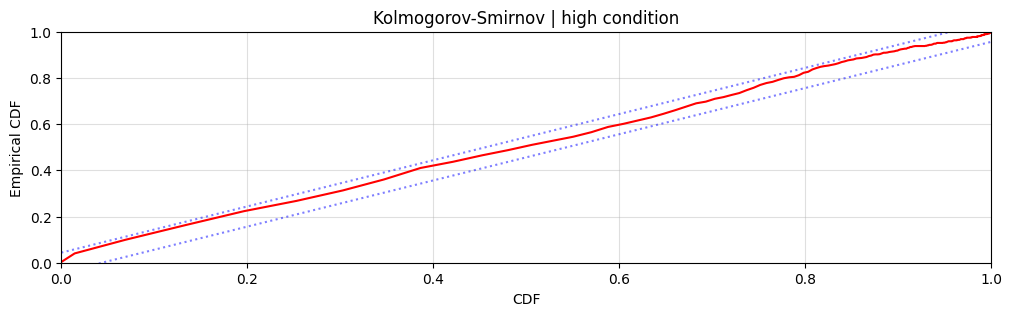

mu_low = 0.039988397284383186       |    mu_high = 0.030941974963219623
lambda_low = 0.04931816769253932    |    lambda_high = 0.009498135387175857


In [31]:
# use the following parameters:
# mu_low (mean of the ISI's... the mu of the inverse gaussian, low light)
# mu_high (mean of the ISI's... the mu of the inverse gaussian, high light)
# lambda_low (shape parameter of the inverse gaussion, low light)
# lambda_high (shape parameter of the inverse gaussion, low light)
# inv_gaussian_low (inverse gaussion model, low light)
# inv_gaussian_high (inverse gaussion model, high light)
# CDF_invgauss_low (CDF of inverse gaussian function, low light)
# CDF_invgauss_high (CDF of inverse gaussian function, high light)

#######################
##   Q4.1 solution   ##
#######################

# low condition
mu_low = np.mean(ISI_low)
lambda_low = 1 / np.mean(1 / ISI_low - 1 / mu_low)

inv_gaussian_low = ( sqrt(lambda_low / (2 * np.pi * bin_edges ** 3)) * exp(-lambda_low * (bin_edges - mu_low) ** 2 / (2 * mu_low ** 2 * bin_edges)) * 0.001)
inv_gaussian_low[0] = 0          

# high condition
mu_high = np.mean(ISI_high)
lambda_high = 1 / np.mean(1 / ISI_high - 1 / mu_high)

inv_gaussian_high = ( sqrt(lambda_high / (2 * np.pi * bin_edges ** 3)) * exp(-lambda_high * (bin_edges - mu_high) ** 2 / (2 * mu_high ** 2 * bin_edges)) * 0.001)
inv_gaussian_high[0] = 0          

#######################
##   Q4.2 solution   ##
#######################

# low condition
# plotting the model and data
counts, bins_l = np.histogram(ISI_low, bin_edges)  
prob = counts / len(ISI_low)             
plt.bar(bin_edges[:-1], prob, width=bin_size)     
plt.plot(bin_edges, inv_gaussian_low, 'r')                   
plt.xlim([0, 0.2])                       
plt.xlabel('ISIs(s)')                        
plt.ylabel('Probability')
plt.show()

# plotting Kolmogorov-Smirnov
CDF_invgauss_low = cumsum(inv_gaussian_low[:-1])          
CDF_emp_low = cumsum(prob)                
plt.plot(CDF_invgauss_low, CDF_emp_low, color='r')                   
plt.plot([0, 1], arange(2) + 1.36 / sqrt(N_low), ':', color='b', alpha=0.5)  
plt.plot([0, 1], arange(2) - 1.36 / sqrt(N_low), ':', color='b', alpha=0.5)  
plt.axis([0, 1, 0, 1])                   
plt.xlabel('CDF')                      
plt.ylabel('Empirical CDF')
plt.title("Kolmogorov-Smirnov | low condition")
plt.grid(alpha=0.4)
plt.show()


# high condition
# plotting the model and data
counts, bins_l = np.histogram(ISI_high, bin_edges)  
prob = counts / len(ISI_high)             
plt.bar(bin_edges[:-1], prob, width=bin_size)     
plt.plot(bin_edges, inv_gaussian_high, 'r')                   
plt.xlim([0, 0.2])                       
plt.xlabel('ISIs(s)')                        
plt.ylabel('Probability')
plt.show()

# plotting Kolmogorov-Smirnov
CDF_invgauss_high = cumsum(inv_gaussian_high[:-1])          
CDF_emp_high = cumsum(prob)                
plt.plot(CDF_invgauss_high, CDF_emp_high, color='r')                   
plt.plot([0, 1], arange(2) + 1.36 / sqrt(N_high), ':', color='b', alpha=0.5)  
plt.plot([0, 1], arange(2) - 1.36 / sqrt(N_high), ':', color='b', alpha=0.5)  
plt.axis([0, 1, 0, 1])                   
plt.xlabel('CDF')                      
plt.ylabel('Empirical CDF')
plt.title("Kolmogorov-Smirnov | high condition")
plt.grid(alpha=0.4)
plt.show()

#######################
##   Q4.3 solution   ##
#######################

print(f'mu_low = {mu_low}       |    mu_high = {mu_high}')       
print(f'lambda_low = {lambda_low}    |    lambda_high = {lambda_high}')


<div class="alert alert-success">
<span style="color:black">
    
**A4 conclusion** 

\begin{tcolorbox}[colback=green!5]
    
Your answer here

\end{tcolorbox}
</span>

#### A5: From Decoding to Encoding models  <a id="A5"></a>
* [Go back to Q5](#Q5) 

In [ ]:
# use the same parameters as in previous questions.

#####################
##   Q5 solution   ##
#####################




<div class="alert alert-success">
<span style="color:black">
    
**A5 conclusion** 

\begin{tcolorbox}[colback=green!5]
    
Your answer here

\end{tcolorbox}
</span>

#### A6: Inhomogenous integrate-and-fire encoder model  <a id="A6"></a>
* [Go back to Q6](#Q6) 

In [1]:
# use the following parameters for Q6.1: 

# rate_white (your rate over time signal with H=0.5 with an average of 80 spikes/s)
# rate_LRD (your rate over time signal with H=0.95 with an average of 80 spikes/s)
# ACF_white (autocorrelation of rate_white for the first 1000 data points)
# ACF_LRD (autocorrelation of rate_LRD for the first 1000 data points)

# plot the first 1000 data points, not all 30000
# similar for the autocorrelation, plot both ACF's in one figure

# use the following parameters for Q6.2: 
# spiketimes_white (the first output parameter of the inhomPP function, H=0.5)
# spiketimes_LRD (the first output parameter of the inhomPP function, H=0.95)

#######################
##   Q6.1 solution   ##
#######################



#######################
##   Q6.2 solution   ##
#######################

# Your Code Goes Here



<div class="alert alert-success">
<span style="color:black">
    
**A6.1 conclusion** 

\begin{tcolorbox}[colback=green!5]
    
Your answer here

\end{tcolorbox}
</span>

<div class="alert alert-success">
<span style="color:black">
    
**A6.2 conclusion** 

\begin{tcolorbox}[colback=green!5]
    
Your answer here

\end{tcolorbox}
</span>

#### A7: Investigate the research hypothesis  <a id="A7"></a>
* [Go back to Q7](#Q7) 

In [ ]:
# Your Code Goes Here




In [ ]:
# Make the figures here




<div class="alert alert-success">
<span style="color:black">
    
**A7 conclusion** 

\begin{tcolorbox}[colback=green!5]
    
Your answer here

\end{tcolorbox}
</span>